In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!unzip '/content/drive/MyDrive/BP_data_Cabrini2017_New.zip'

Archive:  /content/drive/MyDrive/BP_data_Cabrini2017_New.zip
   creating: BP_data_Cabrini2017_New/
   creating: BP_data_Cabrini2017_New/01_NOV_09_F/
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/01_NOV_09.xls  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/01_NOV_09P1.txt  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/01_NOV_09P2.txt  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/01_NOV_09_CLEAR_INDX.xlsx  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test1_1.mat  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test1_2.mat  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test1_3.mat  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test1_4.mat  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test1_5.mat  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test1_6.mat  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test2_1.mat  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test2_2.mat  
  inflating: BP_data_Cabrini2017_New/01_NOV_09_F/test2_3.mat  
  inflat

In [ ]:
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.signal

def butter_lowpass_filter(signal, cutoff=5, fs=1000, order=3):
    nyquist = 0.4 * fs
    normal_cutoff = cutoff / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='low', analog=False)
    return scipy.signal.filtfilt(b, a, signal)

def process_mat_files(file_paths, fs=1000, cutoff=5, order=3, output_csv=None):
    all_rows = []
    row_info = []

    for file_path in file_paths:
        print(f"Processing file: {file_path}")
        try:
            mat_contents = sio.loadmat(file_path)
            data = mat_contents['data']
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
            continue

        for i in range(180):
            try:
                ecg_signal    = data[0][i][0][0][0][2]
                ppg_signal    = data[0][i][0][0][0][4]
                bioimp_signal = data[0][i][0][0][0][3]
            except Exception as e:
                print(f"Index error in file {file_path} at index {i}: {e}")
                continue

            ecg_filtered    = butter_lowpass_filter(ecg_signal, cutoff=cutoff, fs=fs, order=order)
            ppg_filtered    = butter_lowpass_filter(ppg_signal, cutoff=cutoff, fs=fs, order=order)
            bioimp_filtered = butter_lowpass_filter(bioimp_signal, cutoff=cutoff, fs=fs, order=order)

            combined_row = np.concatenate([ecg_filtered, ppg_filtered, bioimp_filtered])
            all_rows.append(combined_row)
            row_info.append((file_path, i))

    if len(all_rows) == 0:
        raise ValueError("No data was processed. Please check the file paths and data structure.")

    total_signal_length = len(all_rows[0])
    num_samples = total_signal_length // 3

    columns = ['file', 'case_index']
    ecg_columns    = [f'ecg_{j+1}' for j in range(num_samples)]
    ppg_columns    = [f'ppg_{j+1}' for j in range(num_samples)]
    bioimp_columns = [f'bioimp_{j+1}' for j in range(num_samples)]
    columns.extend(ecg_columns)
    columns.extend(ppg_columns)
    columns.extend(bioimp_columns)

    data_rows = []
    for (file_path, case_idx), signal_row in zip(row_info, all_rows):
        row = [file_path, case_idx] + list(signal_row)
        data_rows.append(row)

    df = pd.DataFrame(data_rows, columns=columns)

    if output_csv is not None:
        try:
            print(f"DataFrame successfully saved to {output_csv}")
        except Exception as e:
            print(f"Error saving CSV to {output_csv}: {e}")

    return df

In [ ]:
import os
import pandas as pd

def data_preparation_sbp_dbp(folder_path, columns):
    result = folder_path.split('/')[-1]
    name = '_'.join(result.split('_')[:-1])
    patient1_data = os.path.join(folder_path, f'{name}P1.txt')
    patient2_data = os.path.join(folder_path, f'{name}P2.txt')

    df1 = pd.read_csv(patient1_data, delimiter=';', skiprows=8)
    df1=df1.iloc[:,0:11]
    df1.columns = columns
    df2 = pd.read_csv(patient2_data, delimiter=';', skiprows=8)
    df2=df2.iloc[:,0:11]
    df2.columns = columns

    # Function to find available .mat files for a given patient
    def get_available_mat_files(folder, prefix):
        return sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.startswith(prefix) and f.endswith('.mat')])

    # Get available mat files for each patient
    p1_matfiles = get_available_mat_files(folder_path, 'test1_')
    p2_matfiles = get_available_mat_files(folder_path, 'test2_')

    # Process available .mat files
    df_combinedp1 = process_mat_files(p1_matfiles, fs=1000, cutoff=5, order=3, output_csv='combined_signals.csv') if p1_matfiles else pd.DataFrame()
    df_combinedp2 = process_mat_files(p2_matfiles, fs=1000, cutoff=5, order=3, output_csv='combined_signals.csv') if p2_matfiles else pd.DataFrame()

    # Filter out rows where 'Systolic (mmHg)' is 0
    df1 = df1[df1['Systolic (mmHg)'] != 0].reset_index(drop=True)
    df2 = df2[df2['Systolic (mmHg)'] != 0].reset_index(drop=True)

    # Trim patient data to match signal data length
    if not df_combinedp1.empty:
        df1_trimmed = df1.iloc[:len(df_combinedp1)]
        final_dfp1 = pd.concat([df_combinedp1, df1_trimmed], axis=1)
    else:
        final_dfp1 = pd.DataFrame()  # Empty DataFrame if no .mat files found

    if not df_combinedp2.empty:
        df2_trimmed = df2.iloc[:len(df_combinedp2)]
        final_dfp2 = pd.concat([df_combinedp2, df2_trimmed], axis=1)
    else:
        final_dfp2 = pd.DataFrame()  # Empty DataFrame if no .mat files found

    # Combine both patients' data
    combined_final_df_p1_p2 = pd.concat([final_dfp1, final_dfp2]) if not final_dfp1.empty or not final_dfp2.empty else pd.DataFrame()

    return combined_final_df_p1_p2


In [ ]:
import os
main_folder = "/content/BP_data_Cabrini2017_New"

all_folder_paths = []

for root, dirs, _ in os.walk(main_folder):
    for directory in dirs:
        full_path = os.path.join(root, directory)
        all_folder_paths.append(full_path)
print(all_folder_paths)


['/content/BP_data_Cabrini2017_New/01_NOV_15_F', '/content/BP_data_Cabrini2017_New/18_OCT_15_M', '/content/BP_data_Cabrini2017_New/25_OCT_17_M', '/content/BP_data_Cabrini2017_New/25_OCT_11_M', '/content/BP_data_Cabrini2017_New/25_OCT_20_F', '/content/BP_data_Cabrini2017_New/25_OCT_13_M', '/content/BP_data_Cabrini2017_New/01_NOV_09_F', '/content/BP_data_Cabrini2017_New/01_NOV_13_F', '/content/BP_data_Cabrini2017_New/18_OCT_14_M', '/content/BP_data_Cabrini2017_New/25_OCT_10_M', '/content/BP_data_Cabrini2017_New/25_OCT_16_F', '/content/BP_data_Cabrini2017_New/25_OCT_19_F']


In [ ]:
len(all_folder_paths)

12

In [ ]:
columns=['Time (s)', 'Systolic (mmHg)', 'Diastolic (mmHg)', 'Mean (mmHg)',
       'Heart rate (bpm)', 'Stroke Volume (ml)', 'LVET (ms)',
       'Pulse Interval (ms)', 'Maximum Slope (mmHg/s)',
       'Cardiac Output (l/min)', 'TPR (dyn.s/cm5)']

In [ ]:
len(columns)

11

In [ ]:
from tqdm import tqdm  # Import tqdm for progress bar

df_list = []

# Process each folder path with a progress bar
for folder_path in tqdm(all_folder_paths, desc="Processing Folders", unit="folder"):
    df = data_preparation_sbp_dbp(folder_path, columns)
    df_list.append(df)

# Concatenate all data into a final DataFrame
df_data = pd.concat(df_list, ignore_index=True)


Processing Folders:   0%|          | 0/12 [00:00<?, ?folder/s]

Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test2_5.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_15_F/test2_6.mat


Processing Folders:   8%|▊         | 1/12 [00:04<00:47,  4.29s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_15_M/test2_4.mat


Processing Folders:  17%|█▋        | 2/12 [00:07<00:37,  3.75s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test2_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_17_M/test2_6.mat


Processing Folders:  25%|██▌       | 3/12 [00:11<00:34,  3.84s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_11_M/test2_4.mat


Processing Folders:  33%|███▎      | 4/12 [00:15<00:29,  3.70s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test2_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_20_F/test2_6.mat


Processing Folders:  42%|████▏     | 5/12 [00:19<00:26,  3.84s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test2_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_13_M/test2_6.mat


Processing Folders:  50%|█████     | 6/12 [00:23<00:23,  3.87s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test2_5.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_09_F/test2_6.mat


Processing Folders:  58%|█████▊    | 7/12 [00:27<00:19,  3.96s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test2_5.mat
Processing file: /content/BP_data_Cabrini2017_New/01_NOV_13_F/test2_6.mat


Processing Folders:  67%|██████▋   | 8/12 [00:31<00:15,  3.99s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/18_OCT_14_M/test2_5.mat


Processing Folders:  75%|███████▌  | 9/12 [00:34<00:11,  3.87s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_10_M/test2_5.mat


Processing Folders:  83%|████████▎ | 10/12 [00:38<00:07,  3.84s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test2_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_16_F/test2_6.mat


Processing Folders:  92%|█████████▏| 11/12 [00:42<00:03,  3.86s/folder]

DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test1_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test1_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test1_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test1_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test1_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test1_6.mat
DataFrame successfully saved to combined_signals.csv
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test2_1.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test2_2.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test2_3.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test2_4.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test2_5.mat
Processing file: /content/BP_data_Cabrini2017_New/25_OCT_19_F/test2_6.mat


Processing Folders: 100%|██████████| 12/12 [00:46<00:00,  3.87s/folder]

DataFrame successfully saved to combined_signals.csv


In [ ]:
df_data

,file,case_index,ecg_1,ecg_2,ecg_3,ecg_4,ecg_5,ecg_6,ecg_7,ecg_8,...,Systolic (mmHg),Diastolic (mmHg),Mean (mmHg),Heart rate (bpm),Stroke Volume (ml),LVET (ms),Pulse Interval (ms),Maximum Slope (mmHg/s),Cardiac Output (l/min),TPR (dyn.s/cm5)
0,/content/BP_data_Cabrini2017_New/01_NOV_15_F/t...,0,2145.449101,2145.416409,2145.383069,2145.349096,2145.314506,2145.279312,2145.243531,2145.207181,...,77,33,48,55,85.0,320,1100,667,4.6,621
1,/content/BP_data_Cabrini2017_New/01_NOV_15_F/t...,1,2147.877365,2148.035511,2148.192774,2148.349022,2148.504126,2148.657957,2148.810389,2148.961298,...,77,35,48,54,82.8,320,1110,646,4.5,644
2,/content/BP_data_Cabrini2017_New/01_NOV_15_F/t...,2,2157.419546,2157.252030,2157.085680,2156.920632,2156.757021,2156.594978,2156.434628,2156.276095,...,73,37,47,55,74.5,310,1100,617,4.1,690
3,/content/BP_data_Cabrini2017_New/01_NOV_15_F/t...,3,2156.669743,2156.366509,2156.064002,2155.762449,2155.462077,2155.163109,2154.865764,2154.570257,...,74,37,48,54,79.5,320,1110,596,4.3,670
4,/content/BP_data_Cabrini2017_New/01_NOV_15_F/t...,4,2147.242901,2147.066785,2146.890948,2146.715538,2146.540699,2146.366576,2146.193315,2146.021059,...,73,39,49,54,76.5,320,1105,579,4.2,701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24835,/content/BP_data_Cabrini2017_New/25_OCT_19_F/t...,175,1978.601375,1981.007433,1983.413926,1985.818882,1988.220342,1990.616365,1993.005037,1995.384474,...,182,82,109,104,95.3,300,575,2142,9.9,660
24836,/content/BP_data_Cabrini2017_New/25_OCT_19_F/t...,176,2055.517730,2056.868569,2058.199255,2059.508858,2060.796488,2062.061291,2063.302452,2064.519195,...,179,78,107,103,98.0,290,580,2138,10.1,632
24837,/content/BP_data_Cabrini2017_New/25_OCT_19_F/t...,177,1887.136469,1892.465473,1897.780932,1903.078788,1908.355027,1913.605689,1918.826882,1924.014786,...,179,80,106,106,95.5,285,565,2096,10.1,624
24838,/content/BP_data_Cabrini2017_New/25_OCT_19_F/t...,178,2196.830414,2193.070738,2189.330561,2185.612546,2181.919305,2178.253398,2174.617328,2171.013533,...,181,74,107,107,103.5,300,560,2271,11.1,579


In [ ]:
df_data=df_data.drop(['file','case_index','Time (s)'],axis=1)

In [ ]:
df_data

,ecg_1,ecg_2,ecg_3,ecg_4,ecg_5,ecg_6,ecg_7,ecg_8,ecg_9,ecg_10,...,Systolic (mmHg),Diastolic (mmHg),Mean (mmHg),Heart rate (bpm),Stroke Volume (ml),LVET (ms),Pulse Interval (ms),Maximum Slope (mmHg/s),Cardiac Output (l/min),TPR (dyn.s/cm5)
0,2145.449101,2145.416409,2145.383069,2145.349096,2145.314506,2145.279312,2145.243531,2145.207181,2145.170277,2145.132837,...,77,33,48,55,85.0,320,1100,667,4.6,621
1,2147.877365,2148.035511,2148.192774,2148.349022,2148.504126,2148.657957,2148.810389,2148.961298,2149.110564,2149.258070,...,77,35,48,54,82.8,320,1110,646,4.5,644
2,2157.419546,2157.252030,2157.085680,2156.920632,2156.757021,2156.594978,2156.434628,2156.276095,2156.119496,2155.964945,...,73,37,47,55,74.5,310,1100,617,4.1,690
3,2156.669743,2156.366509,2156.064002,2155.762449,2155.462077,2155.163109,2154.865764,2154.570257,2154.276801,2153.985601,...,74,37,48,54,79.5,320,1110,596,4.3,670
4,2147.242901,2147.066785,2146.890948,2146.715538,2146.540699,2146.366576,2146.193315,2146.021059,2145.849949,2145.680127,...,73,39,49,54,76.5,320,1105,579,4.2,701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24835,1978.601375,1981.007433,1983.413926,1985.818882,1988.220342,1990.616365,1993.005037,1995.384474,1997.752828,2000.108291,...,182,82,109,104,95.3,300,575,2142,9.9,660
24836,2055.517730,2056.868569,2058.199255,2059.508858,2060.796488,2062.061291,2063.302452,2064.519195,2065.710784,2066.876527,...,179,78,107,103,98.0,290,580,2138,10.1,632
24837,1887.136469,1892.465473,1897.780932,1903.078788,1908.355027,1913.605689,1918.826882,1924.014786,1929.165664,1934.275871,...,179,80,106,106,95.5,285,565,2096,10.1,624
24838,2196.830414,2193.070738,2189.330561,2185.612546,2181.919305,2178.253398,2174.617328,2171.013533,2167.444385,2163.912181,...,181,74,107,107,103.5,300,560,2271,11.1,579


In [ ]:
df_data.shape

(24840, 3010)

In [ ]:
df=df_data.copy()


***Objective 1***

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

df=df_data.copy()

# Define feature categories
target_columns = ["Systolic (mmHg)", "Diastolic (mmHg)"]  # SBP and DBP as targets
medical_features = [
    "Mean (mmHg)", "Heart rate (bpm)", "Stroke Volume (ml)", "LVET (ms)",
    "Pulse Interval (ms)", "Maximum Slope (mmHg/s)", "Cardiac Output (l/min)", "TPR (dyn.s/cm5)"
]
ecg_features = [f"ecg_{i}" for i in range(1, 1001)]
ppg_features = [f"ppg_{i}" for i in range(1, 1001)]
bioimpedance_features = [f"bioimp_{i}" for i in range(1, 1001)]

# Function to extract key features from signals
def extract_signal_features(signal_values):
    peaks, _ = find_peaks(signal_values)
    num_peaks = len(peaks)
    peak_mean = np.mean(signal_values[peaks]) if num_peaks > 0 else 0
    peak_std = np.std(signal_values[peaks]) if num_peaks > 0 else 0
    min_val = np.min(signal_values)
    max_val = np.max(signal_values)
    return num_peaks, peak_mean, peak_std, min_val, max_val

# Extract features for ECG, PPG, and Bioimpedance
extracted_features = []

for index, row in df.iterrows():
    ecg_values = row[ecg_features].values
    ppg_values = row[ppg_features].values
    bioimpedance_values = row[bioimpedance_features].values

    ecg_feats = extract_signal_features(ecg_values)
    ppg_feats = extract_signal_features(ppg_values)
    bio_feats = extract_signal_features(bioimpedance_values)

    extracted_features.append(list(ecg_feats) + list(ppg_feats) + list(bio_feats))

# Create new DataFrame with extracted features
feature_columns = [
    "ecg_peaks", "ecg_peak_mean", "ecg_peak_std", "ecg_min", "ecg_max",
    "ppg_peaks", "ppg_peak_mean", "ppg_peak_std", "ppg_min", "ppg_max",
    "bio_peaks", "bio_peak_mean", "bio_peak_std", "bio_min", "bio_max"
]

df_extracted = pd.DataFrame(extracted_features, columns=feature_columns)

# Combine with medical features and target columns
final_df1 = pd.concat([df[medical_features], df_extracted, df[target_columns]], axis=1)


In [ ]:
final_df1

,Mean (mmHg),Heart rate (bpm),Stroke Volume (ml),LVET (ms),Pulse Interval (ms),Maximum Slope (mmHg/s),Cardiac Output (l/min),TPR (dyn.s/cm5),ecg_peaks,ecg_peak_mean,...,ppg_peak_std,ppg_min,ppg_max,bio_peaks,bio_peak_mean,bio_peak_std,bio_min,bio_max,Systolic (mmHg),Diastolic (mmHg)
0,48,55,85.0,320,1100,667,4.6,621,3,2145.330780,...,515.160947,1829.999872,3043.903976,2,2301.561887,156.439430,2098.023155,2458.001317,77,33
1,48,54,82.8,320,1110,646,4.5,644,5,2153.897707,...,0.000000,1714.101306,2889.408954,2,2253.747658,65.586537,2130.701270,2407.216731,77,35
2,47,55,74.5,310,1100,617,4.1,690,4,2148.359448,...,0.000000,1687.089429,2595.020522,1,1698.730379,0.000000,1582.048192,2129.837968,73,37
3,48,54,79.5,320,1110,596,4.3,670,5,2142.918934,...,0.000000,1641.324144,2322.854489,0,0.000000,0.000000,1164.683286,1615.342818,74,37
4,49,54,76.5,320,1105,579,4.2,701,5,2140.777935,...,308.032847,1686.508155,2360.822443,3,1489.292101,70.890191,1398.332094,1588.279150,73,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24835,109,104,95.3,300,575,2142,9.9,660,5,2079.052738,...,0.000000,1838.073343,2258.005089,4,1774.744069,79.288034,1633.046682,1824.019321,182,82
24836,107,103,98.0,290,580,2138,10.1,632,5,2081.506695,...,170.973954,1869.219187,2296.139235,3,1661.608732,55.661455,1581.621667,1740.242010,179,78
24837,106,106,95.5,285,565,2096,10.1,624,4,2080.822706,...,19.788792,1851.914825,2288.512653,1,1588.880280,0.000000,1305.946193,1588.880280,179,80
24838,107,107,103.5,300,560,2271,11.1,579,3,2076.908306,...,174.144019,1890.858512,2272.813349,1,1791.612396,0.000000,1538.934615,1791.612396,181,74


In [ ]:
final_df1=final_df1.dropna(axis=0)

In [ ]:
final_df1.isnull().sum().sum()

0

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(final_df1.drop(columns=target_columns))
y = scaler_y.fit_transform(final_df1[target_columns])

# Define test set size
test_size = 3583

# Split dataset: First, separate the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Determine the size of training and validation sets
val_size = 0.125  # Since we need 10% validation out of the remaining data

# Split remaining data into training (70%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)

# Print dataset sizes to verify
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 18599
Validation set size: 2658
Testing set size: 3583


In [ ]:
# Reshape data for CNN (1D convolution expects (samples, timesteps, features))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define 1D CNN Model
model = keras.Sequential([
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='linear')  # Predicting SBP and DBP
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    sde = np.std(y_true - y_pred)
    return mse, rmse, mae, sde

# Compute metrics for SBP and DBP
metrics_sbp = calculate_metrics(y_test_unscaled[:, 0], y_pred[:, 0])
metrics_dbp = calculate_metrics(y_test_unscaled[:, 1], y_pred[:, 1])

# Print metrics
print(f"SBP - MSE: {metrics_sbp[0]:.4f}, RMSE: {metrics_sbp[1]:.4f}, MAE: {metrics_sbp[2]:.4f}, SDE: {metrics_sbp[3]:.4f}")
print(f"DBP - MSE: {metrics_dbp[0]:.4f}, RMSE: {metrics_dbp[1]:.4f}, MAE: {metrics_dbp[2]:.4f}, SDE: {metrics_dbp[3]:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.4508 - mae: 0.4867 - val_loss: 0.0792 - val_mae: 0.2013
Epoch 2/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1625 - mae: 0.2822 - val_loss: 0.0594 - val_mae: 0.1728
Epoch 3/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1124 - mae: 0.2437 - val_loss: 0.0522 - val_mae: 0.1638
Epoch 4/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0944 - mae: 0.2256 - val_loss: 0.0562 - val_mae: 0.1736
Epoch 5/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0912 - mae: 0.2206 - val_loss: 0.0470 - val_mae: 0.1514
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0824 - mae: 0.2126 - val_loss: 0.0497 - val_mae: 0.1584
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0793 - mae: 0.2067 - val_loss: 0.0453 - val_mae: 0.1539
Epoch 8/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0816 - mae: 0.2061 - val_loss: 0.0406 - val_mae: 0.1391
Epoch 9/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

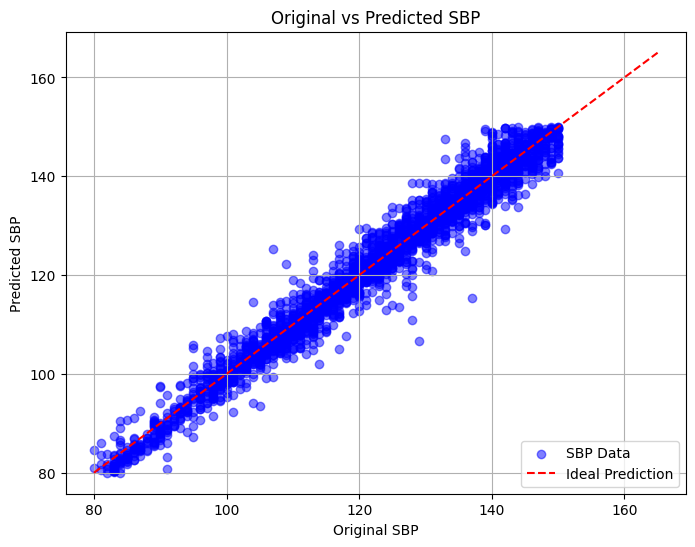

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the SBP valid range
sbp_min, sbp_max = 80, 150

# Filter based on original values
valid_indices_original = (y_test_unscaled[:, 0] >= sbp_min) & (y_test_unscaled[:, 0] <= sbp_max)
y_test_filtered_original = y_test_unscaled[valid_indices_original]
y_pred_filtered_original = y_pred[valid_indices_original]

# Filter based on predicted values
valid_indices_pred = (y_pred_filtered_original[:, 0] >= sbp_min) & (y_pred_filtered_original[:, 0] <= sbp_max)
y_test_filtered_final = y_test_filtered_original[valid_indices_pred]
y_pred_filtered_final = y_pred_filtered_original[valid_indices_pred]

# Plot the filtered data
plt.figure(figsize=(8, 6))
plt.scatter(y_test_filtered_final[:, 0], y_pred_filtered_final[:, 0], alpha=0.5, label="SBP Data", color='blue')
plt.plot([min(y_test_filtered_final[:, 0]), max(y_test_filtered_final[:, 0])+15],
         [min(y_test_filtered_final[:, 0]), max(y_test_filtered_final[:, 0])+15], 'r--', label="Ideal Prediction")
plt.xlabel("Original SBP")
plt.ylabel("Predicted SBP")
plt.title("Original vs Predicted SBP")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


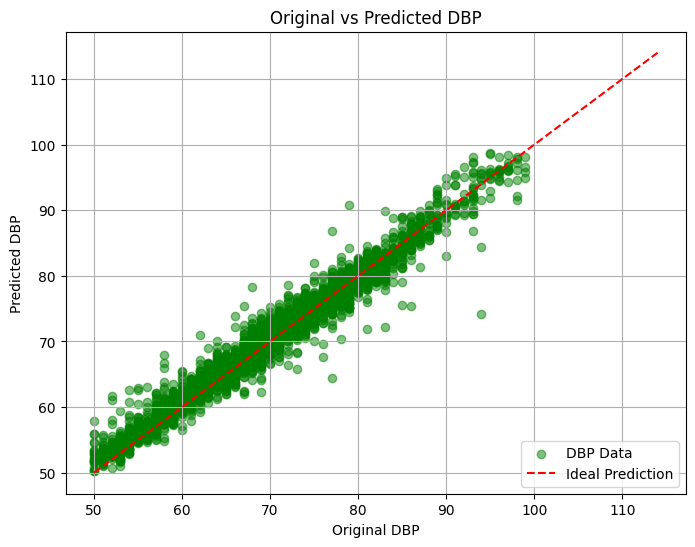

In [ ]:
dbp_min, dbp_max = 50, 100

# Filter based on original values
valid_indices_original_dbp = (y_test_unscaled[:, 1] >= dbp_min) & (y_test_unscaled[:, 1] <= dbp_max)
y_test_filtered_original_dbp = y_test_unscaled[valid_indices_original_dbp]
y_pred_filtered_original_dbp = y_pred[valid_indices_original_dbp]

# Filter based on predicted values
valid_indices_pred_dbp = (y_pred_filtered_original_dbp[:, 1] >= dbp_min) & (y_pred_filtered_original_dbp[:, 1] <= dbp_max)
y_test_filtered_final_dbp = y_test_filtered_original_dbp[valid_indices_pred_dbp]
y_pred_filtered_final_dbp = y_pred_filtered_original_dbp[valid_indices_pred_dbp]

# Plot the filtered data
plt.figure(figsize=(8, 6))
plt.scatter(y_test_filtered_final_dbp[:, 1], y_pred_filtered_final_dbp[:, 1], alpha=0.5, label="DBP Data", color='green')
plt.plot([min(y_test_filtered_final_dbp[:, 1]), max(y_test_filtered_final_dbp[:, 1])+15],
         [min(y_test_filtered_final_dbp[:, 1]), max(y_test_filtered_final_dbp[:, 1])+15], 'r--', label="Ideal Prediction")
plt.xlabel("Original DBP")
plt.ylabel("Predicted DBP")
plt.title("Original vs Predicted DBP")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

***Objective 3***

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.2 MB/s eta 0:00:00


In [ ]:
df

,ecg_1,ecg_2,ecg_3,ecg_4,ecg_5,ecg_6,ecg_7,ecg_8,ecg_9,ecg_10,...,Systolic (mmHg),Diastolic (mmHg),Mean (mmHg),Heart rate (bpm),Stroke Volume (ml),LVET (ms),Pulse Interval (ms),Maximum Slope (mmHg/s),Cardiac Output (l/min),TPR (dyn.s/cm5)
0,2145.449101,2145.416409,2145.383069,2145.349096,2145.314506,2145.279312,2145.243531,2145.207181,2145.170277,2145.132837,...,77,33,48,55,85.0,320,1100,667,4.6,621
1,2147.877365,2148.035511,2148.192774,2148.349022,2148.504126,2148.657957,2148.810389,2148.961298,2149.110564,2149.258070,...,77,35,48,54,82.8,320,1110,646,4.5,644
2,2157.419546,2157.252030,2157.085680,2156.920632,2156.757021,2156.594978,2156.434628,2156.276095,2156.119496,2155.964945,...,73,37,47,55,74.5,310,1100,617,4.1,690
3,2156.669743,2156.366509,2156.064002,2155.762449,2155.462077,2155.163109,2154.865764,2154.570257,2154.276801,2153.985601,...,74,37,48,54,79.5,320,1110,596,4.3,670
4,2147.242901,2147.066785,2146.890948,2146.715538,2146.540699,2146.366576,2146.193315,2146.021059,2145.849949,2145.680127,...,73,39,49,54,76.5,320,1105,579,4.2,701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24835,1978.601375,1981.007433,1983.413926,1985.818882,1988.220342,1990.616365,1993.005037,1995.384474,1997.752828,2000.108291,...,182,82,109,104,95.3,300,575,2142,9.9,660
24836,2055.517730,2056.868569,2058.199255,2059.508858,2060.796488,2062.061291,2063.302452,2064.519195,2065.710784,2066.876527,...,179,78,107,103,98.0,290,580,2138,10.1,632
24837,1887.136469,1892.465473,1897.780932,1903.078788,1908.355027,1913.605689,1918.826882,1924.014786,1929.165664,1934.275871,...,179,80,106,106,95.5,285,565,2096,10.1,624
24838,2196.830414,2193.070738,2189.330561,2185.612546,2181.919305,2178.253398,2174.617328,2171.013533,2167.444385,2163.912181,...,181,74,107,107,103.5,300,560,2271,11.1,579


In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pywt

# Define feature categories
target_columns = ["Systolic (mmHg)", "Diastolic (mmHg)"]  # SBP and DBP as targets
medical_features = [
    "Mean (mmHg)", "Heart rate (bpm)", "Stroke Volume (ml)", "LVET (ms)",
    "Pulse Interval (ms)", "Maximum Slope (mmHg/s)", "Cardiac Output (l/min)", "TPR (dyn.s/cm5)"
]
ecg_features = [f"ecg_{i}" for i in range(1, 1001)]
ppg_features = [f"ppg_{i}" for i in range(1, 1001)]
bioimpedance_features = [f"bioimp_{i}" for i in range(1, 1001)]

# Function to apply Butterworth low-pass filter
def butter_lowpass_filter(signal, cutoff=5, fs=1000, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Function to apply wavelet denoising
def wavelet_denoising(signal, wavelet="db4", level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-level]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

# Function to extract key features from signals
def extract_signal_features(signal_values):
    peaks, _ = find_peaks(signal_values)
    num_peaks = len(peaks)
    peak_mean = np.mean(signal_values[peaks]) if num_peaks > 0 else 0
    peak_std = np.std(signal_values[peaks]) if num_peaks > 0 else 0
    min_val = np.min(signal_values)
    max_val = np.max(signal_values)
    return num_peaks, peak_mean, peak_std, min_val, max_val

# Apply denoising and extract features
extracted_features = []
for index, row in df_data.iterrows():
    ecg_values = butter_lowpass_filter(row[ecg_features].values)
    ppg_values = wavelet_denoising(row[ppg_features].values)

    ecg_feats = extract_signal_features(ecg_values)
    ppg_feats = extract_signal_features(ppg_values)

    extracted_features.append(list(ecg_feats) + list(ppg_feats))

# Create new DataFrame with extracted features
feature_columns = [
    "ecg_peaks", "ecg_peak_mean", "ecg_peak_std", "ecg_min", "ecg_max",
    "ppg_peaks", "ppg_peak_mean", "ppg_peak_std", "ppg_min", "ppg_max"
]

df_extracted = pd.DataFrame(extracted_features, columns=feature_columns)

# Combine with medical features and target columns
final_df3 = pd.concat([df[medical_features], df_extracted, df[target_columns]], axis=1)


In [ ]:
final_df3

,Mean (mmHg),Heart rate (bpm),Stroke Volume (ml),LVET (ms),Pulse Interval (ms),Maximum Slope (mmHg/s),Cardiac Output (l/min),TPR (dyn.s/cm5),ecg_peaks,ecg_peak_mean,ecg_peak_std,ecg_min,ecg_max,ppg_peaks,ppg_peak_mean,ppg_peak_std,ppg_min,ppg_max,Systolic (mmHg),Diastolic (mmHg)
0,48,55,85.0,320,1100,667,4.6,621,3,2144.515797,3.267350,2139.995870,2150.767790,2,2528.744822,515.162319,1830.001486,3043.907141,77,33
1,48,54,82.8,320,1110,646,4.5,644,4,2152.896119,2.949583,2148.583523,2157.781406,1,2889.409106,0.000000,1714.100527,2889.409106,77,35
2,47,55,74.5,310,1100,617,4.1,690,3,2147.873170,1.535044,2141.177378,2157.061011,1,2595.018465,0.000000,1687.089896,2595.018465,73,37
3,48,54,79.5,320,1110,596,4.3,670,3,2141.721311,1.028248,2136.978803,2155.517186,1,2321.154358,0.000000,1641.321861,2321.154358,74,37
4,49,54,76.5,320,1105,579,4.2,701,3,2140.279400,1.251617,2136.407717,2146.696352,3,1925.331795,308.032637,1686.509838,2360.822128,73,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24835,109,104,95.3,300,575,2142,9.9,660,4,2078.854016,5.168337,1989.519816,2085.613063,1,2258.006835,0.000000,1838.073966,2258.006835,182,82
24836,107,103,98.0,290,580,2138,10.1,632,3,2081.631470,2.672450,2059.624129,2084.737471,2,2125.166928,170.971809,1869.219818,2296.138738,179,78
24837,106,106,95.5,285,565,2096,10.1,624,4,2080.983476,12.520767,1910.133467,2101.882256,2,2268.725591,19.789974,1851.914808,2288.515565,179,80
24838,107,107,103.5,300,560,2271,11.1,579,3,2076.311695,1.665675,2052.191820,2181.682862,2,2098.670383,174.145120,1890.858527,2272.815503,181,74


In [ ]:
final_df3=final_df3.dropna(axis=0)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(final_df3.drop(columns=target_columns))
y = scaler_y.fit_transform(final_df3[target_columns])

# Define test set size
test_size = 3583

# Split dataset: First, separate the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Determine validation set size (10% of remaining data)
val_size = 0.125  # 10% validation from remaining data

# Split remaining data into training (70%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)


# Reshape data for CNN (1D convolution expects (samples, timesteps, features))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define 1D CNN Model
model3 = keras.Sequential([
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='linear')  # Predicting SBP and DBP
])

# Compile the model
model3.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
model3.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
y_pred_scaled = model3.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    sde = np.std(y_true - y_pred)
    return mse, rmse, mae, sde

# Compute metrics for SBP and DBP
metrics_sbp = calculate_metrics(y_test_unscaled[:, 0], y_pred[:, 0])
metrics_dbp = calculate_metrics(y_test_unscaled[:, 1], y_pred[:, 1])

# Print metrics
print(f"SBP - MSE: {metrics_sbp[0]:.4f}, RMSE: {metrics_sbp[1]:.4f}, MAE: {metrics_sbp[2]:.4f}, SDE: {metrics_sbp[3]:.4f}")
print(f"DBP - MSE: {metrics_dbp[0]:.4f}, RMSE: {metrics_dbp[1]:.4f}, MAE: {metrics_dbp[2]:.4f}, SDE: {metrics_dbp[3]:.4f}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.4617 - mae: 0.4840 - val_loss: 0.0950 - val_mae: 0.2140
Epoch 2/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1216 - mae: 0.2570 - val_loss: 0.0861 - val_mae: 0.2090
Epoch 3/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2029 - mae: 0.2592 - val_loss: 0.0576 - val_mae: 0.1733
Epoch 4/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0947 - mae: 0.2244 - val_loss: 0.0506 - val_mae: 0.1564
Epoch 5/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1074 - mae: 0.2265 - val_loss: 0.0564 - val_mae: 0.1732
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0910 - mae: 0.2201 - val_loss: 0.0459 - val_mae: 0.1500
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0894 - mae: 0.2143 - val_loss: 0.0416 - val_mae: 0.1406
Epoch 8/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0784 - mae: 0.2048 - val_loss: 0.0442 - val_mae: 0.1452
Epoch 9/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0884 

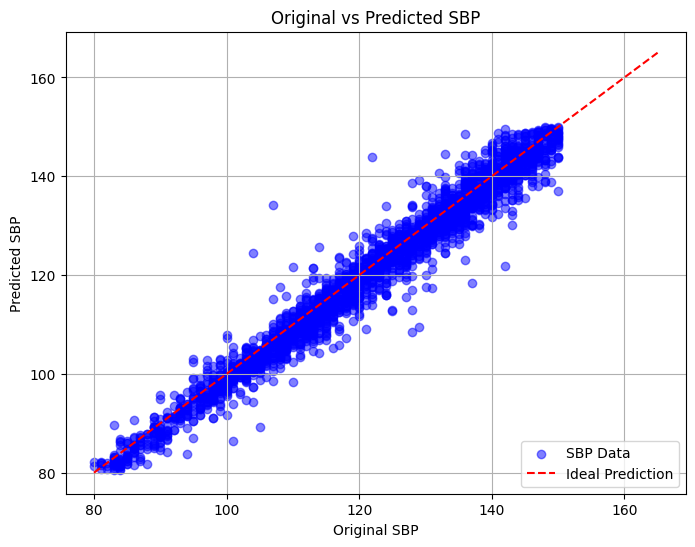

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the SBP valid range
sbp_min, sbp_max = 80, 150

# Filter based on original values
valid_indices_original = (y_test_unscaled[:, 0] >= sbp_min) & (y_test_unscaled[:, 0] <= sbp_max)
y_test_filtered_original = y_test_unscaled[valid_indices_original]
y_pred_filtered_original = y_pred[valid_indices_original]

# Filter based on predicted values
valid_indices_pred = (y_pred_filtered_original[:, 0] >= sbp_min) & (y_pred_filtered_original[:, 0] <= sbp_max)
y_test_filtered_final = y_test_filtered_original[valid_indices_pred]
y_pred_filtered_final = y_pred_filtered_original[valid_indices_pred]

# Plot the filtered data
plt.figure(figsize=(8, 6))
plt.scatter(y_test_filtered_final[:, 0], y_pred_filtered_final[:, 0], alpha=0.5, label="SBP Data", color='blue')
plt.plot([min(y_test_filtered_final[:, 0]), max(y_test_filtered_final[:, 0])+15],
         [min(y_test_filtered_final[:, 0]), max(y_test_filtered_final[:, 0])+15], 'r--', label="Ideal Prediction")
plt.xlabel("Original SBP")
plt.ylabel("Predicted SBP")
plt.title("Original vs Predicted SBP")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


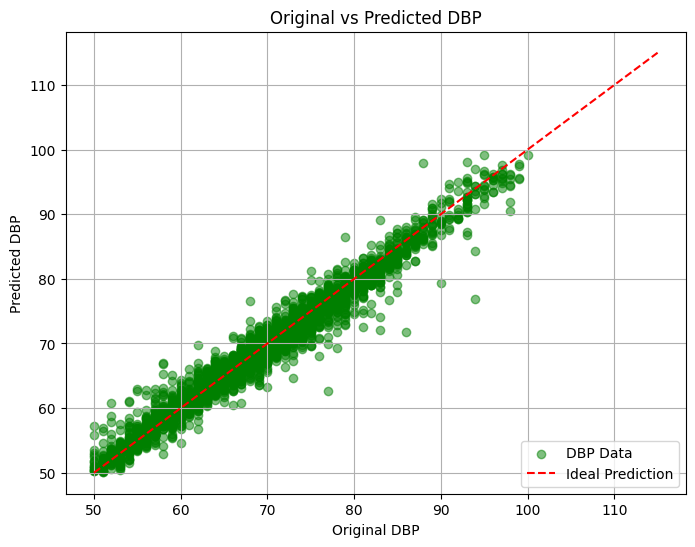

In [ ]:
dbp_min, dbp_max = 50, 100

# Filter based on original values
valid_indices_original_dbp = (y_test_unscaled[:, 1] >= dbp_min) & (y_test_unscaled[:, 1] <= dbp_max)
y_test_filtered_original_dbp = y_test_unscaled[valid_indices_original_dbp]
y_pred_filtered_original_dbp = y_pred[valid_indices_original_dbp]

# Filter based on predicted values
valid_indices_pred_dbp = (y_pred_filtered_original_dbp[:, 1] >= dbp_min) & (y_pred_filtered_original_dbp[:, 1] <= dbp_max)
y_test_filtered_final_dbp = y_test_filtered_original_dbp[valid_indices_pred_dbp]
y_pred_filtered_final_dbp = y_pred_filtered_original_dbp[valid_indices_pred_dbp]

# Plot the filtered data
plt.figure(figsize=(8, 6))
plt.scatter(y_test_filtered_final_dbp[:, 1], y_pred_filtered_final_dbp[:, 1], alpha=0.5, label="DBP Data", color='green')
plt.plot([min(y_test_filtered_final_dbp[:, 1]), max(y_test_filtered_final_dbp[:, 1])+15],
         [min(y_test_filtered_final_dbp[:, 1]), max(y_test_filtered_final_dbp[:, 1])+15], 'r--', label="Ideal Prediction")
plt.xlabel("Original DBP")
plt.ylabel("Predicted DBP")
plt.title("Original vs Predicted DBP")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

***Objective 2***

In [ ]:
final_df1

,Mean (mmHg),Heart rate (bpm),Stroke Volume (ml),LVET (ms),Pulse Interval (ms),Maximum Slope (mmHg/s),Cardiac Output (l/min),TPR (dyn.s/cm5),ecg_peaks,ecg_peak_mean,...,ppg_peak_std,ppg_min,ppg_max,bio_peaks,bio_peak_mean,bio_peak_std,bio_min,bio_max,Systolic (mmHg),Diastolic (mmHg)
0,48,55,85.0,320,1100,667,4.6,621,3,2145.330780,...,515.160947,1829.999872,3043.903976,2,2301.561887,156.439430,2098.023155,2458.001317,77,33
1,48,54,82.8,320,1110,646,4.5,644,5,2153.897707,...,0.000000,1714.101306,2889.408954,2,2253.747658,65.586537,2130.701270,2407.216731,77,35
2,47,55,74.5,310,1100,617,4.1,690,4,2148.359448,...,0.000000,1687.089429,2595.020522,1,1698.730379,0.000000,1582.048192,2129.837968,73,37
3,48,54,79.5,320,1110,596,4.3,670,5,2142.918934,...,0.000000,1641.324144,2322.854489,0,0.000000,0.000000,1164.683286,1615.342818,74,37
4,49,54,76.5,320,1105,579,4.2,701,5,2140.777935,...,308.032847,1686.508155,2360.822443,3,1489.292101,70.890191,1398.332094,1588.279150,73,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24835,109,104,95.3,300,575,2142,9.9,660,5,2079.052738,...,0.000000,1838.073343,2258.005089,4,1774.744069,79.288034,1633.046682,1824.019321,182,82
24836,107,103,98.0,290,580,2138,10.1,632,5,2081.506695,...,170.973954,1869.219187,2296.139235,3,1661.608732,55.661455,1581.621667,1740.242010,179,78
24837,106,106,95.5,285,565,2096,10.1,624,4,2080.822706,...,19.788792,1851.914825,2288.512653,1,1588.880280,0.000000,1305.946193,1588.880280,179,80
24838,107,107,103.5,300,560,2271,11.1,579,3,2076.908306,...,174.144019,1890.858512,2272.813349,1,1791.612396,0.000000,1538.934615,1791.612396,181,74


In [ ]:
columns_to_remove = [col for col in final_df1.columns if col.startswith('ppg') or col.startswith('ecg')]
df2 = final_df1.drop(columns=columns_to_remove)


In [ ]:
df2

,Mean (mmHg),Heart rate (bpm),Stroke Volume (ml),LVET (ms),Pulse Interval (ms),Maximum Slope (mmHg/s),Cardiac Output (l/min),TPR (dyn.s/cm5),bio_peaks,bio_peak_mean,bio_peak_std,bio_min,bio_max,Systolic (mmHg),Diastolic (mmHg)
0,48,55,85.0,320,1100,667,4.6,621,2,2301.561887,156.439430,2098.023155,2458.001317,77,33
1,48,54,82.8,320,1110,646,4.5,644,2,2253.747658,65.586537,2130.701270,2407.216731,77,35
2,47,55,74.5,310,1100,617,4.1,690,1,1698.730379,0.000000,1582.048192,2129.837968,73,37
3,48,54,79.5,320,1110,596,4.3,670,0,0.000000,0.000000,1164.683286,1615.342818,74,37
4,49,54,76.5,320,1105,579,4.2,701,3,1489.292101,70.890191,1398.332094,1588.279150,73,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24835,109,104,95.3,300,575,2142,9.9,660,4,1774.744069,79.288034,1633.046682,1824.019321,182,82
24836,107,103,98.0,290,580,2138,10.1,632,3,1661.608732,55.661455,1581.621667,1740.242010,179,78
24837,106,106,95.5,285,565,2096,10.1,624,1,1588.880280,0.000000,1305.946193,1588.880280,179,80
24838,107,107,103.5,300,560,2271,11.1,579,1,1791.612396,0.000000,1538.934615,1791.612396,181,74


In [ ]:
df2.columns

Index(['Mean (mmHg)', 'Heart rate (bpm)', 'Stroke Volume (ml)', 'LVET (ms)',
       'Pulse Interval (ms)', 'Maximum Slope (mmHg/s)',
       'Cardiac Output (l/min)', 'TPR (dyn.s/cm5)', 'bio_peaks',
       'bio_peak_mean', 'bio_peak_std', 'bio_min', 'bio_max',
       'Systolic (mmHg)', 'Diastolic (mmHg)'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# Define feature categories
target_columns = ["Systolic (mmHg)", "Diastolic (mmHg)"]
feature_columns = [
    "Mean (mmHg)", "Heart rate (bpm)", "Stroke Volume (ml)", "LVET (ms)",
    "Pulse Interval (ms)", "Maximum Slope (mmHg/s)", "Cardiac Output (l/min)", "TPR (dyn.s/cm5)",
    "bio_peaks", "bio_peak_mean", "bio_peak_std", "bio_min", "bio_max"
]

# Extract features and targets
X = df2[feature_columns].values
y = df2[target_columns].values

# Standardize features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# Expand dimensions for CNN compatibility
X = X[..., np.newaxis]

# Define test set size
test_size = 3583

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Define 1D CNN Model for Evidential Deep Learning
def build_evidential_1d_cnn(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    gamma = layers.Dense(2, name="gamma_output")(x)  # Predict Systolic & Diastolic BP
    v = layers.Dense(2, activation='softplus', name="v_output")(x)
    alpha = layers.Dense(2, activation='softplus', name="alpha_output")(x)
    beta = layers.Dense(2, activation='softplus', name="beta_output")(x)
    model = keras.Model(inputs, [gamma, v, alpha, beta])
    return model

# Build model
model2 = build_evidential_1d_cnn(input_shape=X_train.shape[1:])

# Compile model with MSE loss for each output
model2.compile(optimizer='adam', loss=["mse", "mse", "mse", "mse"], metrics=["mae", "mae", "mae", "mae"])

# Train model
history = model2.fit(X_train, [y_train, y_train, y_train, y_train],
                    validation_data=(X_test, [y_test, y_test, y_test, y_test]),
                    epochs=50, batch_size=32)

# Evaluate model
losses = model2.evaluate(X_test, [y_test, y_test, y_test, y_test])
print(f'Test Losses: {losses}')


Epoch 1/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - alpha_output_loss: 0.7244 - alpha_output_mae: 0.6349 - beta_output_loss: 0.7130 - beta_output_mae: 0.6316 - gamma_output_loss: 0.3638 - gamma_output_mae: 0.4026 - loss: 2.5197 - v_output_loss: 0.7184 - v_output_mae: 0.6335 - val_alpha_output_loss: 0.4868 - val_alpha_output_mae: 0.4847 - val_beta_output_loss: 0.4878 - val_beta_output_mae: 0.4862 - val_gamma_output_loss: 0.0716 - val_gamma_output_mae: 0.2079 - val_loss: 1.5341 - val_v_output_loss: 0.4880 - val_v_output_mae: 0.4869
Epoch 2/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - alpha_output_loss: 0.4966 - alpha_output_mae: 0.4883 - beta_output_loss: 0.4967 - beta_output_mae: 0.4885 - gamma_output_loss: 0.0719 - gamma_output_mae: 0.1869 - loss: 1.5616 - v_output_loss: 0.4964 - v_output_mae: 0.4880 - val_alpha_output_loss: 0.4782 - val_alpha_output_mae: 0.4741 - val_beta_output_loss: 0.4782 - val_beta_output_mae: 0.4739 - val_gamma_output_loss: 0.0416 - val_gamma_output_mae: 0.14

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions
y_pred_scaled, _, _, _ = model2.predict(X_test)

# Inverse transform to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    sde = np.std(y_true - y_pred)
    return mse, rmse, mae, sde

# Compute metrics for SBP and DBP
metrics_sbp = calculate_metrics(y_test_unscaled[:, 0], y_pred[:, 0])
metrics_dbp = calculate_metrics(y_test_unscaled[:, 1], y_pred[:, 1])

# Print metrics
print(f"SBP - MSE: {metrics_sbp[0]:.4f}, RMSE: {metrics_sbp[1]:.4f}, MAE: {metrics_sbp[2]:.4f}, SDE: {metrics_sbp[3]:.4f}")
print(f"DBP - MSE: {metrics_dbp[0]:.4f}, RMSE: {metrics_dbp[1]:.4f}, MAE: {metrics_dbp[2]:.4f}, SDE: {metrics_dbp[3]:.4f}")


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
SBP - MSE: 12.7207, RMSE: 3.5666, MAE: 2.4448, SDE: 3.5380
DBP - MSE: 3.7308, RMSE: 1.9315, MAE: 1.2256, SDE: 1.9200


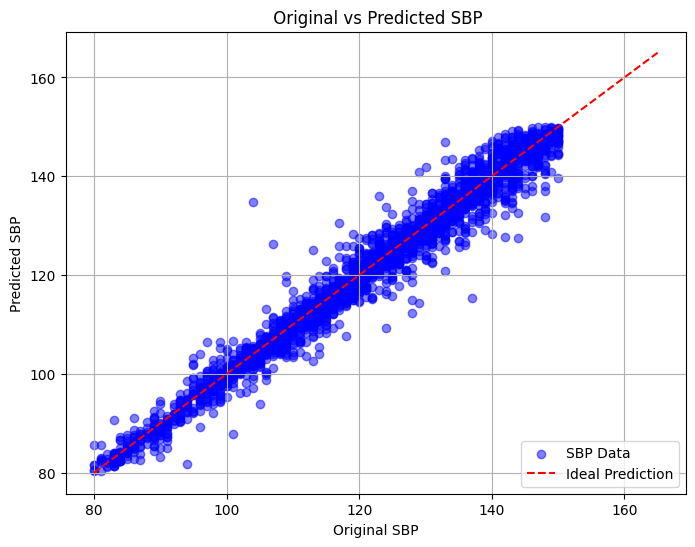

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the SBP valid range
sbp_min, sbp_max = 80, 150

# Filter based on original values
valid_indices_original = (y_test_unscaled[:, 0] >= sbp_min) & (y_test_unscaled[:, 0] <= sbp_max)
y_test_filtered_original = y_test_unscaled[valid_indices_original]
y_pred_filtered_original = y_pred[valid_indices_original]

# Filter based on predicted values
valid_indices_pred = (y_pred_filtered_original[:, 0] >= sbp_min) & (y_pred_filtered_original[:, 0] <= sbp_max)
y_test_filtered_final = y_test_filtered_original[valid_indices_pred]
y_pred_filtered_final = y_pred_filtered_original[valid_indices_pred]

# Plot the filtered data
plt.figure(figsize=(8, 6))
plt.scatter(y_test_filtered_final[:, 0], y_pred_filtered_final[:, 0], alpha=0.5, label="SBP Data", color='blue')
plt.plot([min(y_test_filtered_final[:, 0]), max(y_test_filtered_final[:, 0])+15],
         [min(y_test_filtered_final[:, 0]), max(y_test_filtered_final[:, 0])+15], 'r--', label="Ideal Prediction")
plt.xlabel("Original SBP")
plt.ylabel("Predicted SBP")
plt.title(" Original vs Predicted SBP")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


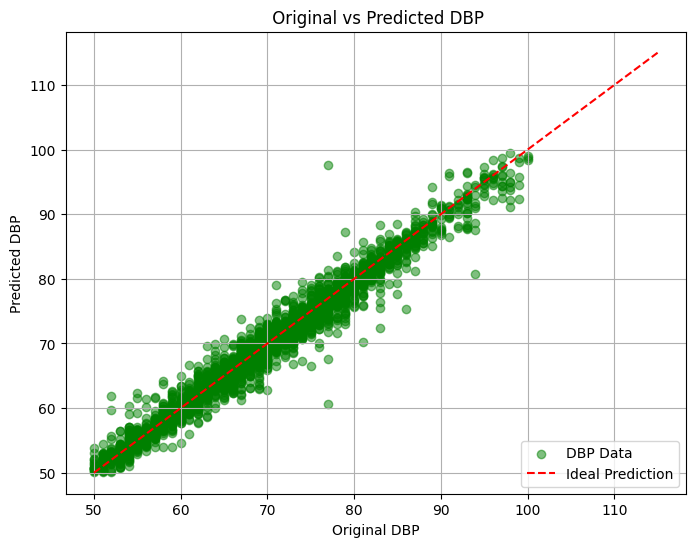

In [ ]:
dbp_min, dbp_max = 50, 100

# Filter based on original values
valid_indices_original_dbp = (y_test_unscaled[:, 1] >= dbp_min) & (y_test_unscaled[:, 1] <= dbp_max)
y_test_filtered_original_dbp = y_test_unscaled[valid_indices_original_dbp]
y_pred_filtered_original_dbp = y_pred[valid_indices_original_dbp]

# Filter based on predicted values
valid_indices_pred_dbp = (y_pred_filtered_original_dbp[:, 1] >= dbp_min) & (y_pred_filtered_original_dbp[:, 1] <= dbp_max)
y_test_filtered_final_dbp = y_test_filtered_original_dbp[valid_indices_pred_dbp]
y_pred_filtered_final_dbp = y_pred_filtered_original_dbp[valid_indices_pred_dbp]

# Plot the filtered data
plt.figure(figsize=(8, 6))
plt.scatter(y_test_filtered_final_dbp[:, 1], y_pred_filtered_final_dbp[:, 1], alpha=0.5, label="DBP Data", color='green')
plt.plot([min(y_test_filtered_final_dbp[:, 1]), max(y_test_filtered_final_dbp[:, 1])+15],
         [min(y_test_filtered_final_dbp[:, 1]), max(y_test_filtered_final_dbp[:, 1])+15], 'r--', label="Ideal Prediction")
plt.xlabel("Original DBP")
plt.ylabel("Predicted DBP")
plt.title(" Original vs Predicted DBP")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()